Github
https://github.com/Shadowjumper3000/ML-fundamentals-2025

# Bike Rental Analysis
This analysis explores patterns in bike rental data to understand key factors influencing rental behavior. The data is sourced from the UCI Machine Learning Repository and contains hourly rental data spanning two years. The analysis is structured as follows:


In [202]:
# Check if running in Kaggle environment
import os
IN_KAGGLE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if IN_KAGGLE:
    # Kaggle-specific paths
    data_path = '/kaggle/input/bike-data/CapitalBikeSharing.csv'
    checkpoint_dir = '/kaggle/working/models'
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Create output directory for downloading models
    os.makedirs('/kaggle/working/output', exist_ok=True)
    
    print("Running in Kaggle environment.")
    print("Data will be loaded from:", data_path)
    print("Models will be saved to:", checkpoint_dir)
else:
    # Local paths
    data_path = '../data/hour.csv'
    checkpoint_dir = '../models/checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("Running in local environment.")
    print("Data will be loaded from:", data_path)
    print("Models will be saved to:", checkpoint_dir)

Running in local environment.
Data will be loaded from: ../data/hour.csv
Models will be saved to: ../models/checkpoints


In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
plt.style.use('default')
sns.set_theme()

# Load the dataset
hour_data = pd.read_csv(data_path)
print("Data loaded from" + data_path)

Data loaded from../data/hour.csv


## 1. Initial Data Exploration
Let's examine the basic structure and statistics of our dataset.
AI was used to write the functions for the analysis.

In [204]:
# Initial Data Exploration
print("Dataset Shape:", hour_data.shape)
print("\nDataset Info:")
print(hour_data.info())
print("\nDescriptive Statistics:")
print(hour_data.describe())

Dataset Shape: (17379, 17)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB
None

D

### 1.1 Target Variable Analysis
Analyzing the distribution of bike rentals (cnt) to understand the general rental patterns.


Skewness of cnt: 1.2774116037490577


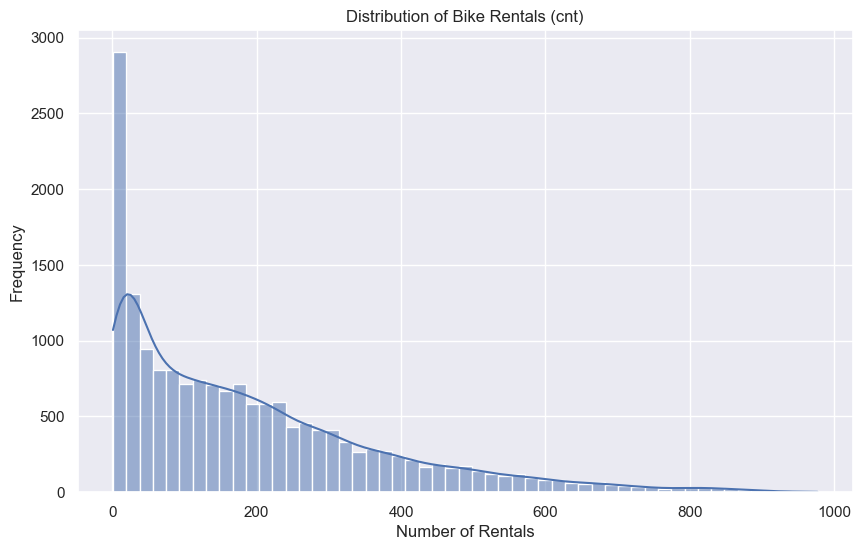

In [205]:
# Target Variable Analysis (cnt)
plt.figure(figsize=(10, 6))
sns.histplot(hour_data['cnt'], kde=True)
plt.title('Distribution of Bike Rentals (cnt)')
plt.xlabel('Number of Rentals')
plt.ylabel('Frequency')
print("\nSkewness of cnt:", hour_data['cnt'].skew())

### 1.2 Temporal Pattern Analysis
Examining how rental patterns vary by hour and season.

2025-04-07 22:02:37,202 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-07 22:02:37,240 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


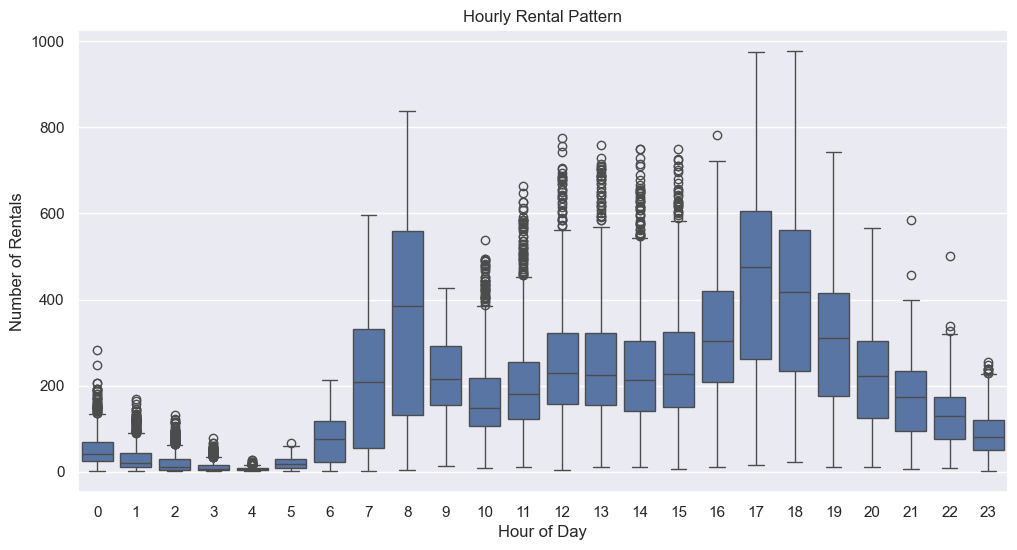

2025-04-07 22:02:37,500 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-07 22:02:37,507 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


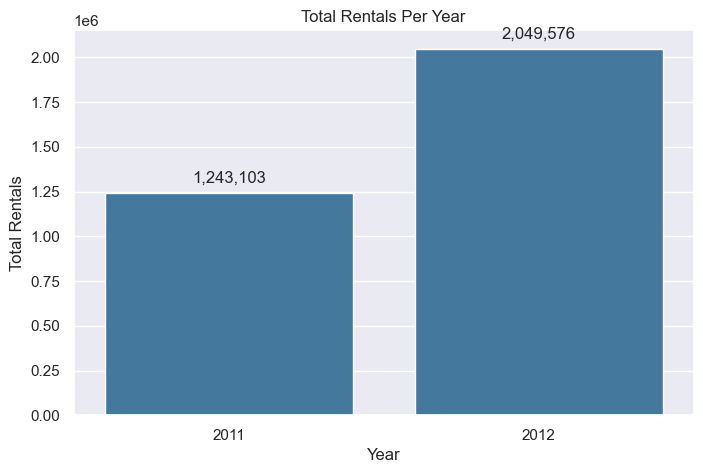

2025-04-07 22:02:37,613 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-07 22:02:37,629 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


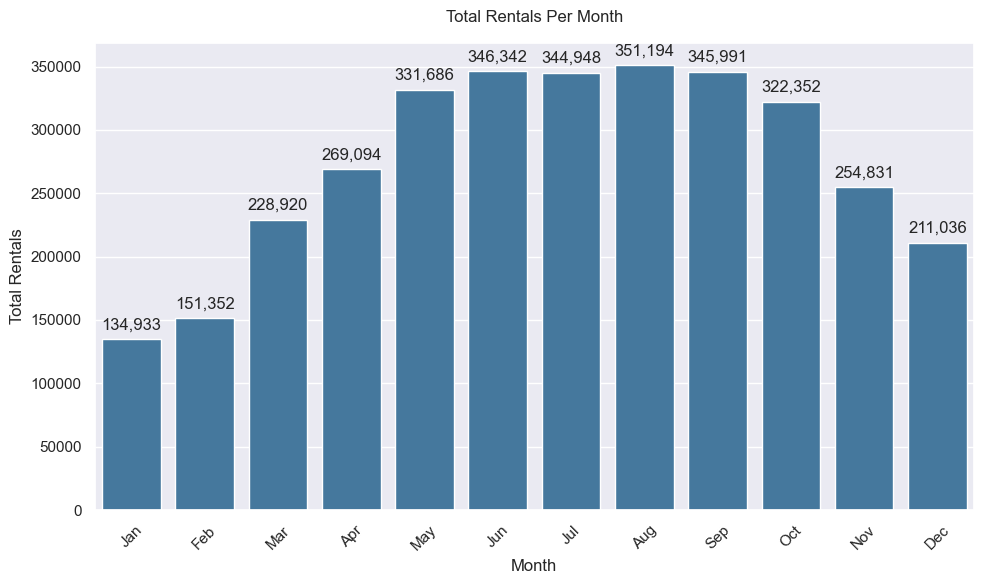

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Hour analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x='hr', y='cnt', data=hour_data)
plt.title('Hourly Rental Pattern')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rentals')
plt.show()

# Rentals per year
# Calculate total rentals per year - safer approach
yearly_rentals = hour_data.groupby('yr')['cnt'].sum().reset_index()
yearly_rentals['year'] = yearly_rentals['yr'].map({0: '2011', 1: '2012'})

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='year', y='cnt', data=yearly_rentals, 
                color=sns.color_palette("Blues_d")[3])
plt.title('Total Rentals Per Year')
plt.xlabel('Year')
plt.ylabel('Total Rentals')

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', 
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='bottom',
               xytext=(0, 5),
               textcoords='offset points')
plt.show()

# Rentals per month
# Calculate total rentals per month - more robust approach
monthly_rentals = hour_data.groupby('mnth')['cnt'].sum().reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='mnth', y='cnt', data=monthly_rentals, 
                color=sns.color_palette("Blues_d")[3])
plt.title('Total Rentals Per Month', pad=15)
plt.xlabel('Month')
plt.ylabel('Total Rentals')
plt.xticks(ticks=range(12), 
          labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
          rotation=45)

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', 
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='bottom',
               xytext=(0, 5),
               textcoords='offset points')

plt.tight_layout()
plt.show()

### 1.3 Holiday and Working Day Analysis
Investigating how holidays and working days affect rental patterns.

2025-04-07 22:02:37,851 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-07 22:02:37,866 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\DAHoe\AppData\Local\Temp\ipykernel_5276\1017616823.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([holiday_labels[i] for i in [0, 1]])
2025-04-07 22:02:37,913 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-07 22:02:37,930 - INFO - Using categorical units to plot a list of str

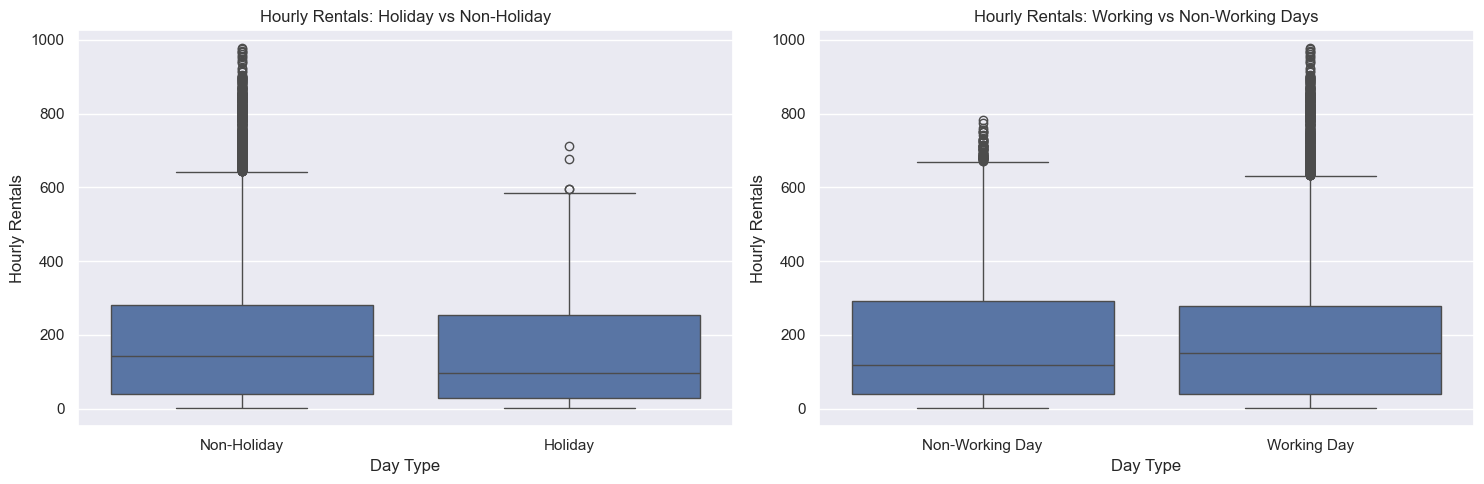

In [207]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Holiday analysis at hourly level
holiday_labels = {0: 'Non-Holiday', 1: 'Holiday'}
sns.boxplot(x='holiday', y='cnt', data=hour_data, ax=ax1)
ax1.set_title('Hourly Rentals: Holiday vs Non-Holiday')
ax1.set_xticklabels([holiday_labels[i] for i in [0, 1]])
ax1.set_xlabel('Day Type')
ax1.set_ylabel('Hourly Rentals')

# Working day analysis at hourly level
workingday_labels = {0: 'Non-Working Day', 1: 'Working Day'}
sns.boxplot(x='workingday', y='cnt', data=hour_data, ax=ax2)
ax2.set_title('Hourly Rentals: Working vs Non-Working Days')
ax2.set_xticklabels([workingday_labels[i] for i in [0, 1]])
ax2.set_xlabel('Day Type')
ax2.set_ylabel('Hourly Rentals')

plt.tight_layout()

### 1.4 Weather Impact Analysis
Analyzing how different weather conditions affect rental behavior.

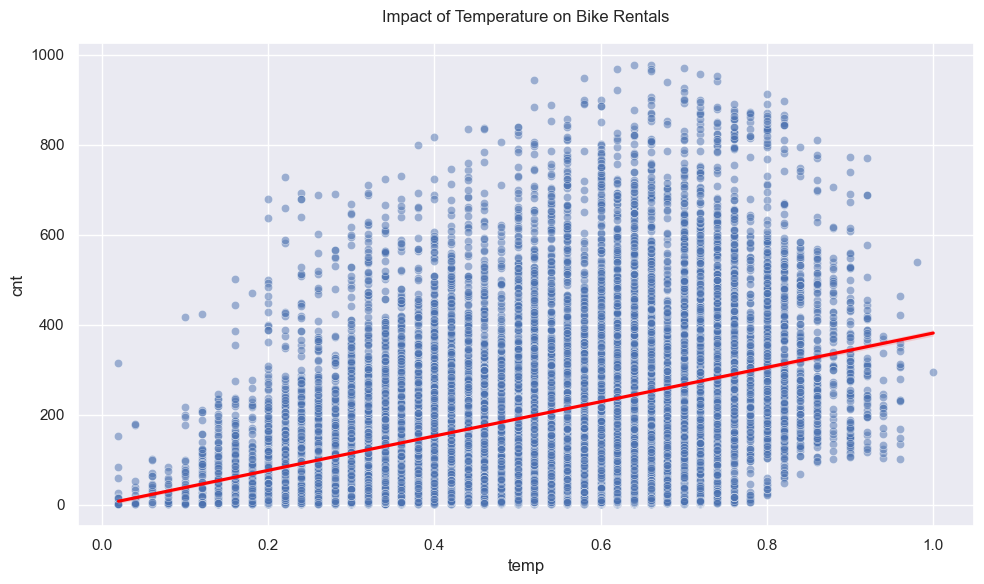

2025-04-07 22:02:39,114 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-07 22:02:39,131 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


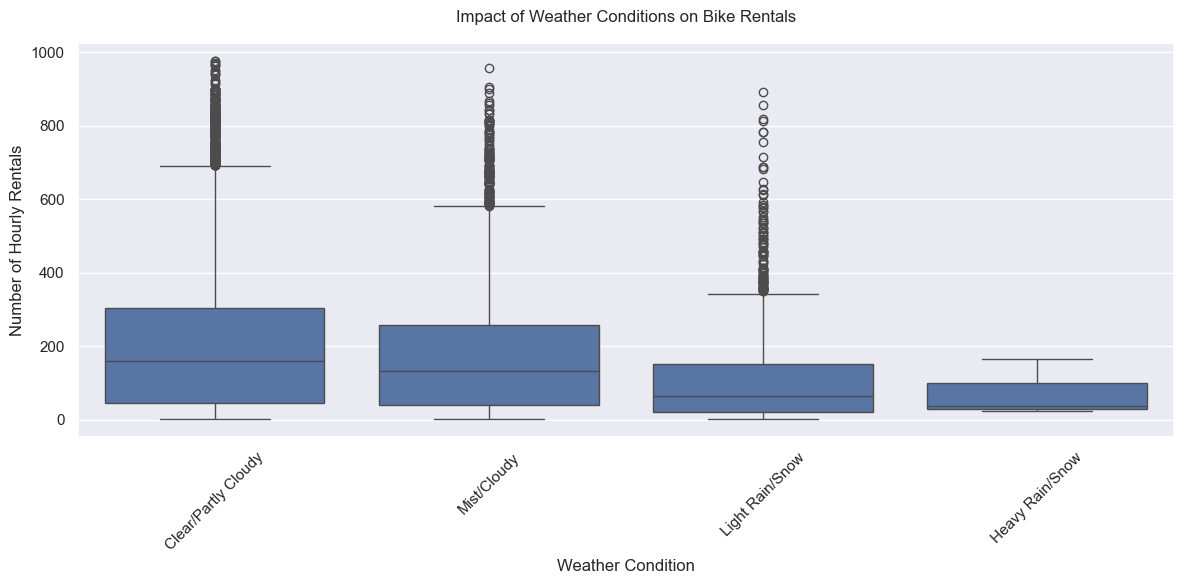

In [208]:
# Define weather situation mapping
weather_labels = {
    1: 'Clear/Partly Cloudy',
    2: 'Mist/Cloudy',
    3: 'Light Rain/Snow',
    4: 'Heavy Rain/Snow'
}

# Temperature vs Count with improved styling
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp', y='cnt', data=hour_data, alpha=0.5)
plt.title('Impact of Temperature on Bike Rentals', pad=15)
plt.xlabel('Temperature (Normalized 0-1 scale)')
plt.ylabel('Number of Hourly Rentals')

# Add trend line
sns.regplot(x='temp', y='cnt', data=hour_data, scatter=False, color='red')

plt.tight_layout()
plt.show()

# Weather Situation vs Count with descriptive labels
plt.figure(figsize=(12, 6))
sns.boxplot(x='weathersit', y='cnt', data=hour_data)
plt.title('Impact of Weather Conditions on Bike Rentals', pad=15)
plt.xlabel('Weather Condition')
plt.ylabel('Number of Hourly Rentals')

# Update x-axis labels with weather descriptions
plt.xticks(range(len(weather_labels)), 
          [weather_labels[i] for i in range(1, 5)], 
          rotation=45)

plt.tight_layout()
plt.show()

### 1.5 Feature Correlation Analysis
Examining relationships between numerical features.

Text(0.5, 1.0, 'Correlation Matrix of Numerical Features')

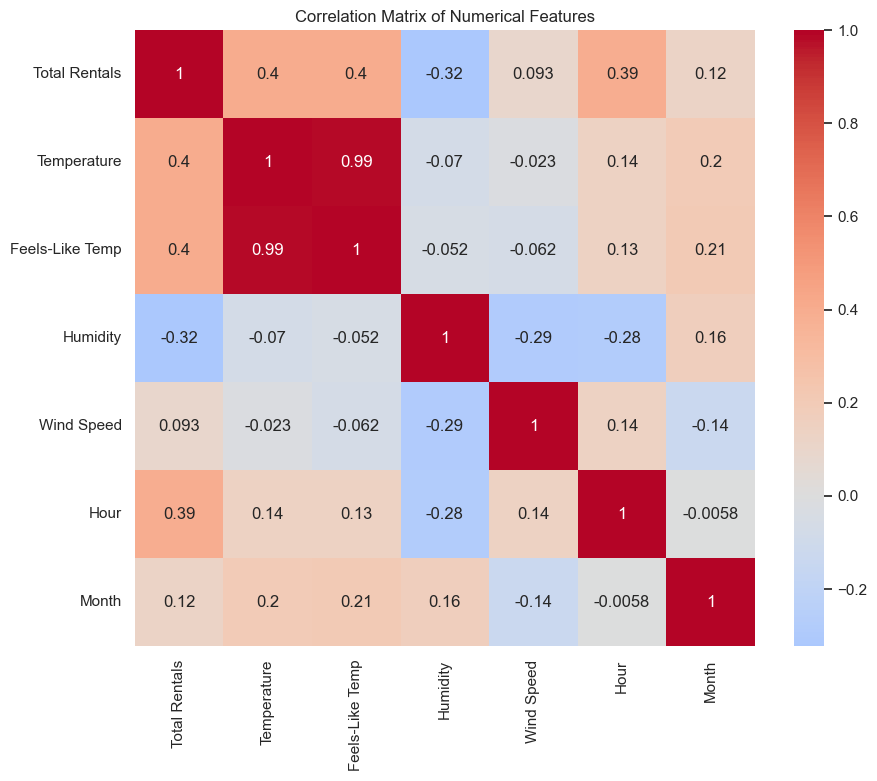

In [209]:
feature_labels = {
    'cnt': 'Total Rentals',
    'temp': 'Temperature',
    'atemp': 'Feels-Like Temp',
    'hum': 'Humidity',
    'windspeed': 'Wind Speed',
    'hr': 'Hour',
    'mnth': 'Month'
}

correlation_features = ['cnt', 'temp', 'atemp', 'hum', 'windspeed', 'hr', 'mnth']
correlation_matrix = hour_data[correlation_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            xticklabels=[feature_labels[col] for col in correlation_features],
            yticklabels=[feature_labels[col] for col in correlation_features])
plt.title('Correlation Matrix of Numerical Features')

In [210]:
# Calculate rental distribution statistics
print("1. Distribution Statistics:")
print(f"Mean rentals: {hour_data['cnt'].mean():.2f}")
print(f"Median rentals: {hour_data['cnt'].median():.2f}")
print(f"Skewness: {hour_data['cnt'].skew():.2f}")

# Calculate peak hours statistics
hourly_avg = hour_data.groupby('hr')['cnt'].mean()
peak_hours = hourly_avg.nlargest(3)
print("\n2. Peak Hours:")
print(peak_hours)

# Calculate weather correlations
print("\n3. Weather Correlations:")
print(f"Temperature correlation: {hour_data['cnt'].corr(hour_data['temp']):.2f}")
print(f"Humidity correlation: {hour_data['cnt'].corr(hour_data['hum']):.2f}")
print(f"Wind speed correlation: {hour_data['cnt'].corr(hour_data['windspeed']):.2f}")

1. Distribution Statistics:
Mean rentals: 189.46
Median rentals: 142.00
Skewness: 1.28

2. Peak Hours:
hr
17    461.452055
18    425.510989
8     359.011004
Name: cnt, dtype: float64

3. Weather Correlations:
Temperature correlation: 0.40
Humidity correlation: -0.32
Wind speed correlation: 0.09


We will drop the 'instant' and 'dteday' columns as they are not needed for our analysis. The 'instant' column is an index, and 'dteday' is a date column that we will not use in our analysis.
'casual' and 'registered' columns are also dropped as they are only gathered after bike rental. We will only use the 'cnt' column as our target variable.

In [211]:
# Drop index-like or redundant columns
columns_to_drop = ['instant', 'dteday', 'casual', 'registered']

# Drop columns and create clean dataset
hour_data_clean = hour_data.drop(columns=columns_to_drop)

print("\nColumns dropped:", columns_to_drop)
print("Remaining columns:", hour_data_clean.columns.tolist())

# Update our working dataset
hour_data = hour_data_clean


Columns dropped: ['instant', 'dteday', 'casual', 'registered']
Remaining columns: ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']


Correlation between temp and atemp: 0.988

Correlations with rental count (cnt):
Temperature: 0.405
Apparent Temperature: 0.401


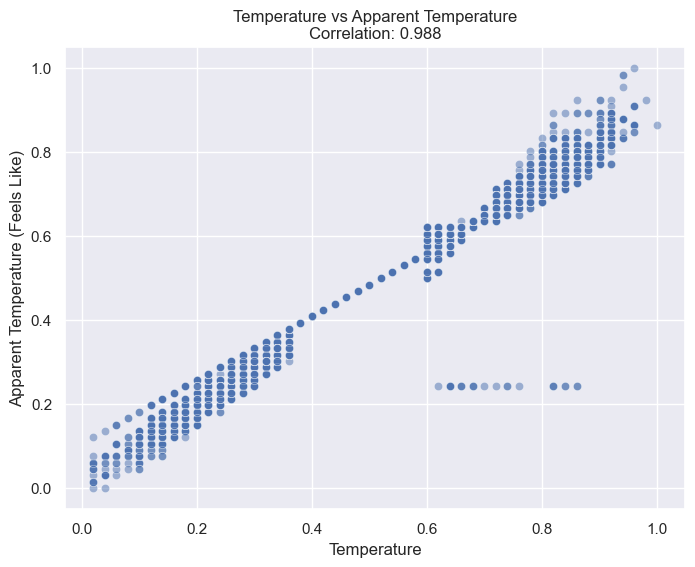

In [212]:
# Calculate correlation between temp and atemp
temp_correlation = hour_data['temp'].corr(hour_data['atemp'])

# Create visualization to show relationship
plt.figure(figsize=(8, 6))
sns.scatterplot(data=hour_data, x='temp', y='atemp', alpha=0.5)
plt.title(f'Temperature vs Apparent Temperature\nCorrelation: {temp_correlation:.3f}')
plt.xlabel('Temperature')
plt.ylabel('Apparent Temperature (Feels Like)')

# Print analysis
print(f"Correlation between temp and atemp: {temp_correlation:.3f}")

# Check their individual correlations with the target variable
temp_target_corr = hour_data['temp'].corr(hour_data['cnt'])
atemp_target_corr = hour_data['atemp'].corr(hour_data['cnt'])

print("\nCorrelations with rental count (cnt):")
print(f"Temperature: {temp_target_corr:.3f}")
print(f"Apparent Temperature: {atemp_target_corr:.3f}")

To avoid multicollinearity, we will drop the `temp` feature as it is highly correlated with `atemp`.

In [213]:
hour_data = hour_data.drop(columns=['temp'])
print("Columns remaining after dropping 'temp':", hour_data.columns.tolist())

Columns remaining after dropping 'temp': ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed', 'cnt']


In [214]:
# Drop any remaining problematic columns
df_clean = hour_data
del hour_data

print("Final columns in cleaned dataset:", df_clean.columns.tolist())


Final columns in cleaned dataset: ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed', 'cnt']


## 2. Data Splitting


We will split our data into three sets:
- Training set (60%): Used to train the model
- Validation set (20%): Used to tune hyperparameters and evaluate model during training
- Test set (20%): Used for final model evaluation

This split helps us:
1. Avoid overfitting by evaluating on unseen data
2. Get an unbiased estimate of model performance
3. Fine-tune model parameters without contaminating test data


In [215]:
X = df_clean.drop('cnt', axis=1)
y = df_clean['cnt']

# Split into train (60%), validation (20%), and test (20%)
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 10427
Validation set size: 3476
Test set size: 3476


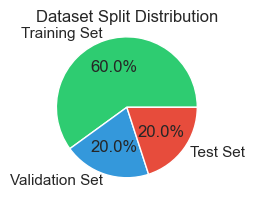

In [216]:
# Create a pie chart showing the data split proportions
import matplotlib.pyplot as plt

# Calculate percentages
total = len(X)
train_pct = len(X_train) / total * 100
val_pct = len(X_val) / total * 100 
test_pct = len(X_test) / total * 100

# Create pie chart
plt.figure(figsize=(2, 2))
plt.pie([train_pct, val_pct, test_pct], 
        labels=['Training Set', 'Validation Set', 'Test Set'],
        autopct='%1.1f%%',
        colors=['#2ecc71', '#3498db', '#e74c3c'])
plt.title('Dataset Split Distribution')
plt.axis('equal')
plt.show()


## 3. Feature Engineering

In [217]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define feature types
numeric_features = ['atemp', 'hum', 'windspeed']
categorical_features = ['season', 'mnth', 'weathersit', 'holiday', 'workingday']
cyclical_features = ['hr', 'weekday']

# Create transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create cyclical feature transformers
def create_cyclical_features(df, col, max_val):
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

# Apply cyclical transformations
X_train_cyclical = X_train.copy()
X_val_cyclical = X_val.copy()
X_test_cyclical = X_test.copy()

for col, max_val in [('hr', 24), ('weekday', 7)]:
    X_train_cyclical = create_cyclical_features(X_train_cyclical, col, max_val)
    X_val_cyclical = create_cyclical_features(X_val_cyclical, col, max_val)
    X_test_cyclical = create_cyclical_features(X_test_cyclical, col, max_val)

# Update feature lists
numeric_features.extend(['hr_sin', 'hr_cos', 'weekday_sin', 'weekday_cos'])
cyclical_features = []  # Remove original cyclical features

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform the data
X_train_processed = preprocessor.fit_transform(X_train_cyclical)
X_val_processed = preprocessor.transform(X_val_cyclical)
X_test_processed = preprocessor.transform(X_test_cyclical)

# Get feature names after transformation
numeric_feature_names = numeric_features
categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

# Convert to DataFrame for easier handling
X_train_processed = pd.DataFrame(X_train_processed, columns=feature_names)
X_val_processed = pd.DataFrame(X_val_processed, columns=feature_names)
X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names)

## 4. Linear Regression

Validation Metrics:
MSE: 17429.4074
MAE: 95.2785
R2: 0.4640


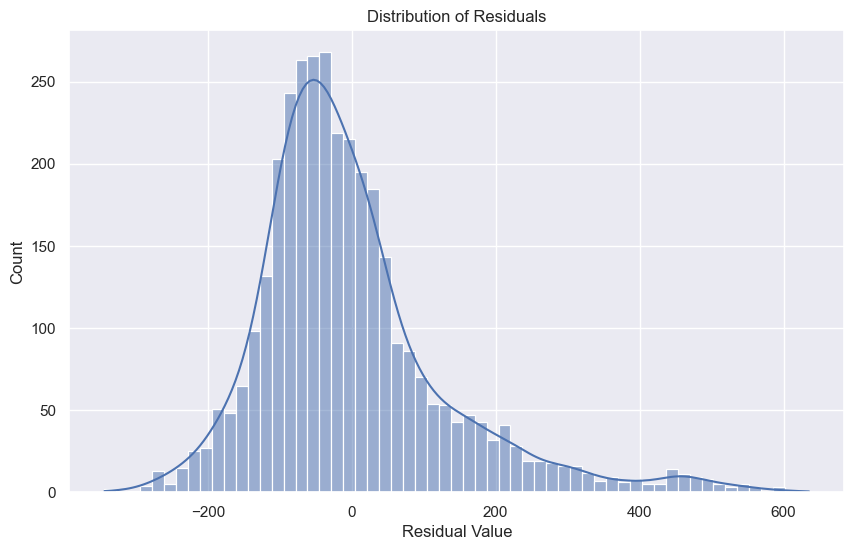


Bias-Variance Analysis:
Training R2: 0.4474
Validation R2: 0.4640


In [218]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train_processed, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train_processed)
y_val_pred = lr_model.predict(X_val_processed)

# Calculate metrics
metrics = {
    'MSE': mean_squared_error(y_val, y_val_pred),
    'MAE': mean_absolute_error(y_val, y_val_pred),
    'R2': r2_score(y_val, y_val_pred)
}

print("Validation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot residuals
plt.figure(figsize=(10, 6))
residuals = y_val - y_val_pred
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.show()

# Analyze bias and variance
print("\nBias-Variance Analysis:")
print(f"Training R2: {r2_score(y_train, y_train_pred):.4f}")
print(f"Validation R2: {r2_score(y_val, y_val_pred):.4f}")

## 5. Random Forest Regression

Random Forest Validation Metrics:
MSE: 4382.5944
MAE: 44.1931
R2: 0.8652


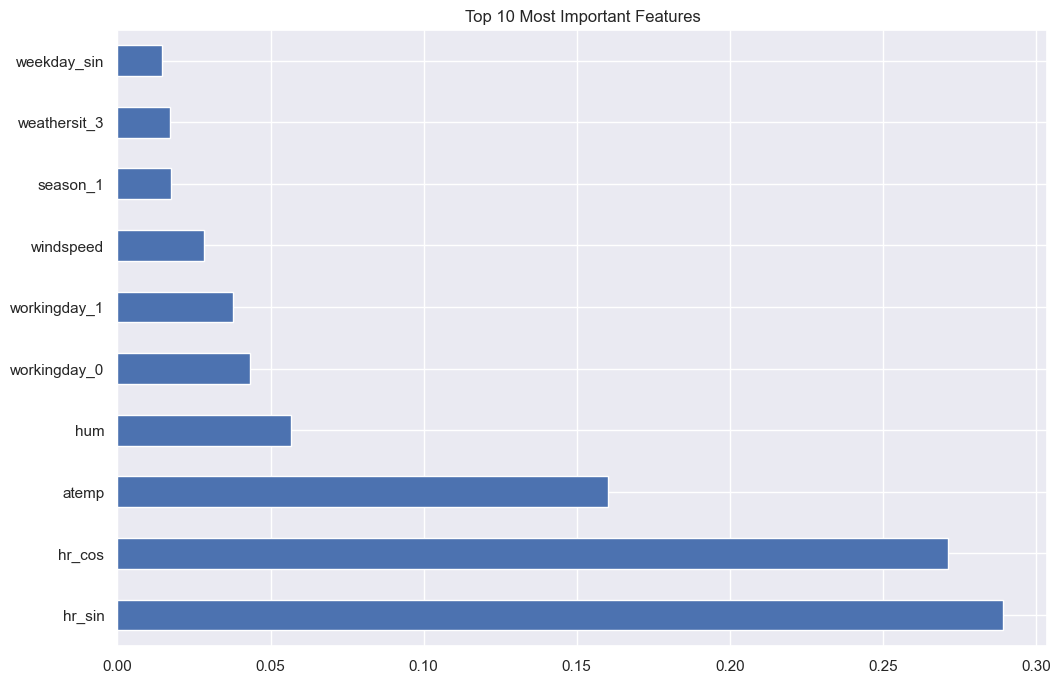


Comparison with Linear Regression:
MSE improvement: -74.86%
MAE improvement: -53.62%
R2 improvement: 86.48%


In [219]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_processed, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train_processed)
y_val_pred_rf = rf_model.predict(X_val_processed)

# Calculate metrics
metrics_rf = {
    'MSE': mean_squared_error(y_val, y_val_pred_rf),
    'MAE': mean_absolute_error(y_val, y_val_pred_rf),
    'R2': r2_score(y_val, y_val_pred_rf)
}

print("Random Forest Validation Metrics:")
for metric, value in metrics_rf.items():
    print(f"{metric}: {value:.4f}")

# Feature importance plot
plt.figure(figsize=(12, 8))
feature_importance = pd.Series(rf_model.feature_importances_, index=feature_names)
feature_importance.nlargest(10).plot(kind='barh')
plt.title('Top 10 Most Important Features')
plt.show()

# Compare with baseline
print("\nComparison with Linear Regression:")
for metric in metrics.keys():
    improvement = (metrics_rf[metric] - metrics[metric]) / abs(metrics[metric]) * 100
    print(f"{metric} improvement: {improvement:.2f}%")

In [220]:
# Save the Random Forest model
import pickle

# Save the current model if tuned version isn't available yet
rf_model_path = os.path.join(checkpoint_dir, 'rf_model.pkl')
with open(rf_model_path, 'wb') as f:
    pickle.dump(rf_model, f)

print(f"Random Forest model saved to {rf_model_path}")

# We'll save the tuned version later after hyperparameter tuning

Random Forest model saved to ../models/checkpoints\rf_model.pkl


## 6. Gradient Boosting

Training XGBoost model...
[0]	validation_0-rmse:144.84150	validation_0-mae:112.17585	validation_1-rmse:142.55536	validation_1-mae:110.77622
[1]	validation_0-rmse:122.94760	validation_0-mae:92.89131	validation_1-rmse:120.68117	validation_1-mae:91.97695
[2]	validation_0-rmse:107.05320	validation_0-mae:78.62635	validation_1-rmse:104.97211	validation_1-mae:78.12828
[3]	validation_0-rmse:95.42876	validation_0-mae:68.58398	validation_1-rmse:93.65143	validation_1-mae:68.41686
[4]	validation_0-rmse:86.39176	validation_0-mae:61.10847	validation_1-rmse:85.74617	validation_1-mae:61.48467
[5]	validation_0-rmse:79.97045	validation_0-mae:56.12334	validation_1-rmse:80.21402	validation_1-mae:57.09476
[6]	validation_0-rmse:76.26483	validation_0-mae:52.96332	validation_1-rmse:77.50528	validation_1-mae:54.57876
[7]	validation_0-rmse:73.50062	validation_0-mae:50.62593	validation_1-rmse:75.48939	validation_1-mae:52.67451
[8]	validation_0-rmse:70.95772	validation_0-mae:48.88695	validation_1-rmse:73.69995	va

c:\Users\DAHoe\Programming\Projects\ML-fundamentals-2025\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [22:02:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()



[70]	validation_0-rmse:45.24708	validation_0-mae:31.17887	validation_1-rmse:63.70511	validation_1-mae:43.57166
[71]	validation_0-rmse:45.09502	validation_0-mae:31.06061	validation_1-rmse:63.71771	validation_1-mae:43.56225
[72]	validation_0-rmse:44.91141	validation_0-mae:30.92698	validation_1-rmse:63.69674	validation_1-mae:43.54156
[73]	validation_0-rmse:44.61673	validation_0-mae:30.75738	validation_1-rmse:63.62875	validation_1-mae:43.49413
[74]	validation_0-rmse:44.57580	validation_0-mae:30.71793	validation_1-rmse:63.61564	validation_1-mae:43.49627
[75]	validation_0-rmse:44.48195	validation_0-mae:30.65234	validation_1-rmse:63.65272	validation_1-mae:43.52766
[76]	validation_0-rmse:44.34480	validation_0-mae:30.55326	validation_1-rmse:63.66694	validation_1-mae:43.54856
[77]	validation_0-rmse:44.18055	validation_0-mae:30.44341	validation_1-rmse:63.61333	validation_1-mae:43.51041
[78]	validation_0-rmse:44.07864	validation_0-mae:30.34029	validation_1-rmse:63.57707	validation_1-mae:43.48730


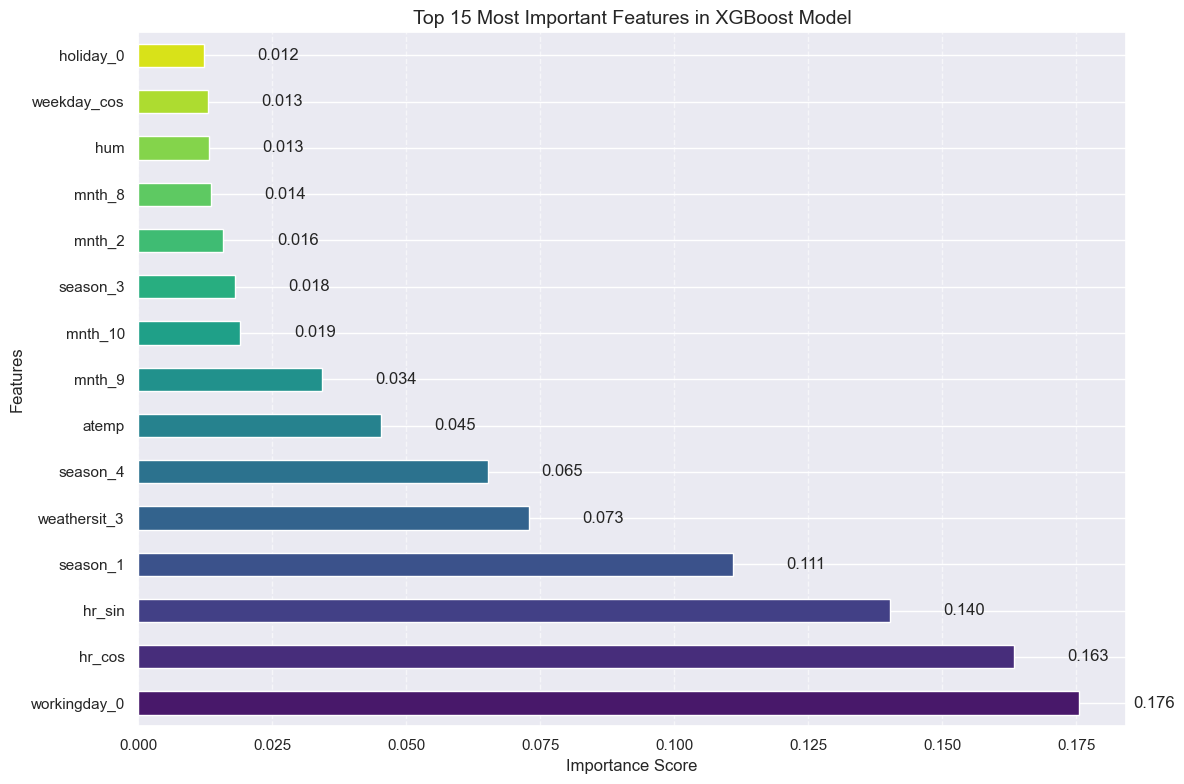

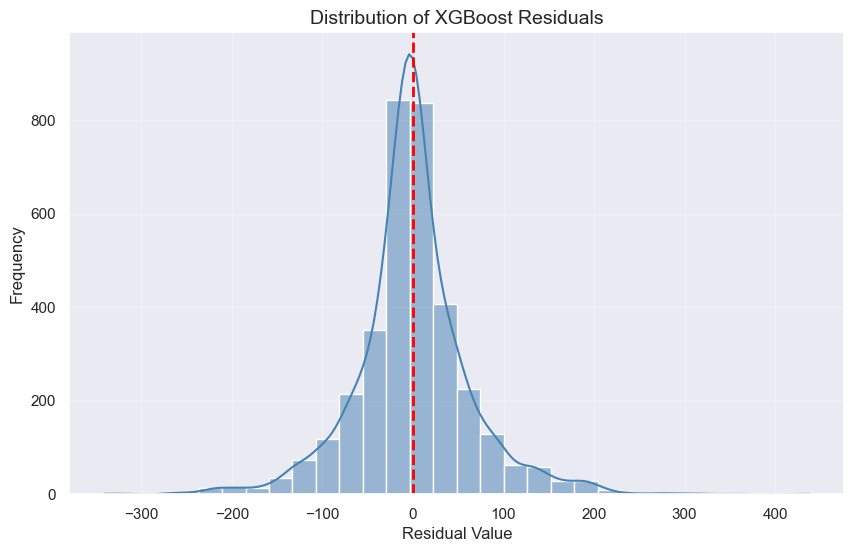

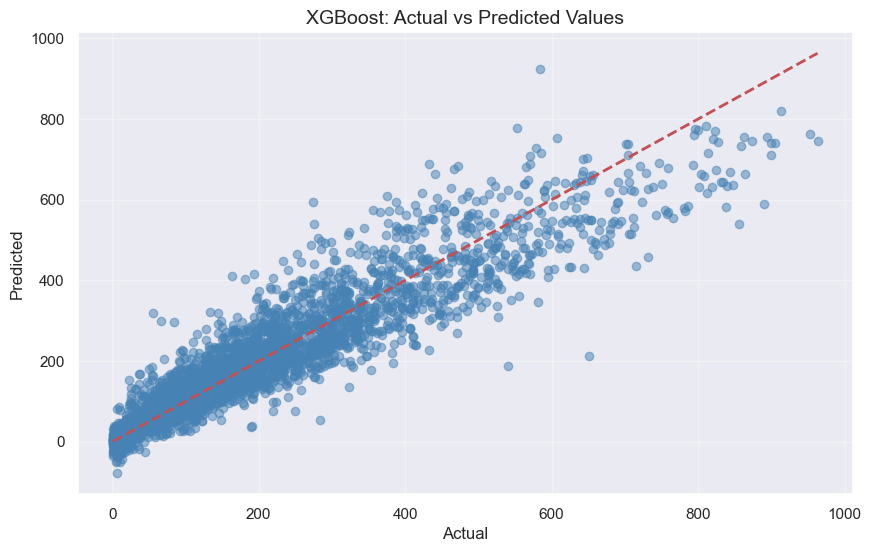


Comparison with Previous Models:
MSE compared to Random Forest: -8.06% (✓ Better)
MSE compared to Linear Regression: -76.88% (✓ Better)
MAE compared to Random Forest: -2.04% (✓ Better)
MAE compared to Linear Regression: -54.56% (✓ Better)
R2 compared to Random Forest: 1.26% (✓ Better)
R2 compared to Linear Regression: 88.82% (✓ Better)


In [221]:
from xgboost import XGBRegressor
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import seaborn as sns

# Start timing
start_time = time.time()

# Initialize and train the model with verbose logging
print("Training XGBoost model...")
xgb_model = XGBRegressor(
    random_state=42, 
    verbose=1,
    eval_metric=['rmse', 'mae'],
    early_stopping_rounds=10  # Move this parameter here
)
xgb_model.fit(
    X_train_processed, 
    y_train, 
    eval_set=[(X_train_processed, y_train), (X_val_processed, y_val)],
    verbose=True  # Keep this to see progress during training
)

# Calculate training time
training_time = time.time() - start_time
print(f"XGBoost training completed in {training_time:.2f} seconds\n")

# Make predictions
y_train_pred_xgb = xgb_model.predict(X_train_processed)
y_val_pred_xgb = xgb_model.predict(X_val_processed)

# Calculate comprehensive metrics
train_metrics = {
    'MSE': mean_squared_error(y_train, y_train_pred_xgb),
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_xgb)),
    'MAE': mean_absolute_error(y_train, y_train_pred_xgb),
    'R2': r2_score(y_train, y_train_pred_xgb),
    'Explained Variance': explained_variance_score(y_train, y_train_pred_xgb)
}

val_metrics = {
    'MSE': mean_squared_error(y_val, y_val_pred_xgb),
    'RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred_xgb)),
    'MAE': mean_absolute_error(y_val, y_val_pred_xgb),
    'R2': r2_score(y_val, y_val_pred_xgb),
    'Explained Variance': explained_variance_score(y_val, y_val_pred_xgb)
}

# Print metrics in a formatted table
print("XGBoost Performance Metrics:")
print(f"{'Metric':<20} {'Training':<15} {'Validation':<15}")
print("-" * 50)
for metric in train_metrics.keys():
    print(f"{metric:<20} {train_metrics[metric]:<15.4f} {val_metrics[metric]:<15.4f}")

# Plot feature importance
plt.figure(figsize=(12, 8))
feature_importance = pd.Series(xgb_model.feature_importances_, index=feature_names).sort_values(ascending=False)
ax = feature_importance.head(15).plot(kind='barh', 
                                     color=sns.color_palette("viridis", len(feature_importance.head(15))))
plt.title('Top 15 Most Important Features in XGBoost Model', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add value annotations to the bars
for i, v in enumerate(feature_importance.head(15)):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center')
    
plt.tight_layout()
plt.show()

# Plot residuals
plt.figure(figsize=(10, 6))
residuals_xgb = y_val - y_val_pred_xgb
sns.histplot(residuals_xgb, kde=True, bins=30, color='steelblue')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title('Distribution of XGBoost Residuals', fontsize=14)
plt.xlabel('Residual Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred_xgb, alpha=0.5, color='steelblue')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.title('XGBoost: Actual vs Predicted Values', fontsize=14)
plt.xlabel('Actual', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Compare with previous models
print("\nComparison with Previous Models:")
for metric in ['MSE', 'MAE', 'R2']:
    improvement_rf = (val_metrics[metric] - metrics_rf[metric]) / abs(metrics_rf[metric]) * 100
    improvement_lr = (val_metrics[metric] - metrics[metric]) / abs(metrics[metric]) * 100
    
    # Display with colored text for better visualization
    rf_status = "✓ Better" if ((metric == 'R2' and improvement_rf > 0) or 
                               (metric != 'R2' and improvement_rf < 0)) else "✗ Worse"
    lr_status = "✓ Better" if ((metric == 'R2' and improvement_lr > 0) or 
                              (metric != 'R2' and improvement_lr < 0)) else "✗ Worse"
    
    print(f"{metric} compared to Random Forest: {improvement_rf:.2f}% ({rf_status})")
    print(f"{metric} compared to Linear Regression: {improvement_lr:.2f}% ({lr_status})")

## 7. Hyperparameter Tuning

2025-04-07 22:02:47,757 - INFO - Starting hyperparameter tuning process
2025-04-07 22:02:47,762 - INFO - Random Forest parameters to tune: n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features
2025-04-07 22:02:47,767 - INFO - XGBoost parameters to tune: learning_rate, n_estimators, max_depth, subsample, colsample_bytree, gamma, min_child_weight
2025-04-07 22:02:47,769 - INFO - Starting Random Forest hyperparameter tuning
2025-04-07 22:02:47,770 - INFO - Starting RF RandomizedSearchCV with 50 iterations


Defining parameter search spaces...
Random Forest parameters to tune: n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features
XGBoost parameters to tune: learning_rate, n_estimators, max_depth, subsample, colsample_bytree, gamma, min_child_weight

Starting Random Forest hyperparameter tuning...
Running 50 iterations of Random Forest hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


2025-04-07 22:05:12,349 - INFO - Top 5 Random Forest parameter combinations:
2025-04-07 22:05:12,355 - INFO - Rank 38: Score = 4670.9168, Params = {'max_depth': 28, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 179}
2025-04-07 22:05:12,357 - INFO - Rank 11: Score = 4865.7804, Params = {'max_depth': 19, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 99}
2025-04-07 22:05:12,359 - INFO - Rank 7: Score = 4874.9150, Params = {'max_depth': 24, 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 100}
2025-04-07 22:05:12,361 - INFO - Rank 47: Score = 4896.1549, Params = {'max_depth': 29, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 148}
2025-04-07 22:05:12,366 - INFO - Rank 23: Score = 4965.2635, Params = {'max_depth': 16, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 150}
2025-04-07 22:05:12,369 - INFO - Rando


Random Forest tuning completed in 144.60 seconds
Best MSE: 4670.9168
Best Random Forest Parameters:
    max_depth: 28
    max_features: 0.5
    min_samples_leaf: 1
    min_samples_split: 3
    n_estimators: 179

Starting XGBoost hyperparameter tuning...
Running 50 iterations of XGBoost hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


2025-04-07 22:05:33,110 - INFO - Top 5 XGBoost parameter combinations:
2025-04-07 22:05:33,113 - INFO - Rank 6: Score = 4329.7304, Params = {'colsample_bytree': np.float64(0.9862528132298237), 'gamma': np.float64(0.8083973481164611), 'learning_rate': np.float64(0.10138413075201119), 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 133, 'subsample': np.float64(0.6964101864104046)}
2025-04-07 22:05:33,115 - INFO - Rank 26: Score = 4424.7966, Params = {'colsample_bytree': np.float64(0.8783251227163527), 'gamma': np.float64(0.8583588048137198), 'learning_rate': np.float64(0.10778767156056542), 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 139, 'subsample': np.float64(0.8048372233197124)}
2025-04-07 22:05:33,116 - INFO - Rank 43: Score = 4425.9180, Params = {'colsample_bytree': np.float64(0.6777095814048169), 'gamma': np.float64(0.07094091699992766), 'learning_rate': np.float64(0.1290351481641665), 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 192, 'subsample': np.fl


XGBoost tuning completed in 20.72 seconds
Best MSE: 4329.7304
Best XGBoost Parameters:
    colsample_bytree: 0.9862528132298237
    gamma: 0.8083973481164611
    learning_rate: 0.10138413075201119
    max_depth: 7
    min_child_weight: 2
    n_estimators: 133
    subsample: 0.6964101864104046

Evaluating tuned models...


2025-04-07 22:05:34,122 - INFO - Tuned Random Forest - Train metrics: {'MSE': 784.5648366900004, 'RMSE': np.float64(28.01008455342469), 'MAE': 18.354111344148816, 'R2': 0.9765313870028222, 'Explained Variance': 0.9765416227327419}
2025-04-07 22:05:34,124 - INFO - Tuned Random Forest - Validation metrics: {'MSE': 4324.2327618427225, 'RMSE': np.float64(65.75889872741729), 'MAE': 44.3162741647321, 'R2': 0.8670120517786114, 'Explained Variance': 0.8670635416402956}
2025-04-07 22:05:34,124 - INFO - Model evaluation completed in 0.97 seconds
2025-04-07 22:05:34,124 - INFO - Evaluating Tuned XGBoost model
2025-04-07 22:05:34,171 - INFO - Tuned XGBoost - Train metrics: {'MSE': 1678.820556640625, 'RMSE': np.float64(40.97341280196983), 'MAE': 28.045677185058594, 'R2': 0.949781596660614, 'Explained Variance': 0.9497820542894113}
2025-04-07 22:05:34,173 - INFO - Tuned XGBoost - Validation metrics: {'MSE': 4006.0966796875, 'RMSE': np.float64(63.29373333662267), 'MAE': 42.20194625854492, 'R2': 0.876


Tuned Random Forest Performance Metrics:
Metric               Training        Validation     
--------------------------------------------------
MSE                  784.5648        4324.2328      
RMSE                 28.0101         65.7589        
MAE                  18.3541         44.3163        
R2                   0.9765          0.8670         
Explained Variance   0.9765          0.8671         

Tuned XGBoost Performance Metrics:
Metric               Training        Validation     
--------------------------------------------------
MSE                  1678.8206       4006.0967      
RMSE                 40.9734         63.2937        
MAE                  28.0457         42.2019        
R2                   0.9498          0.8768         
Explained Variance   0.9498          0.8768         


2025-04-07 22:05:34,936 - INFO - Comparison visualization saved to ../models/checkpoints/model_comparison_20250407_220533.png


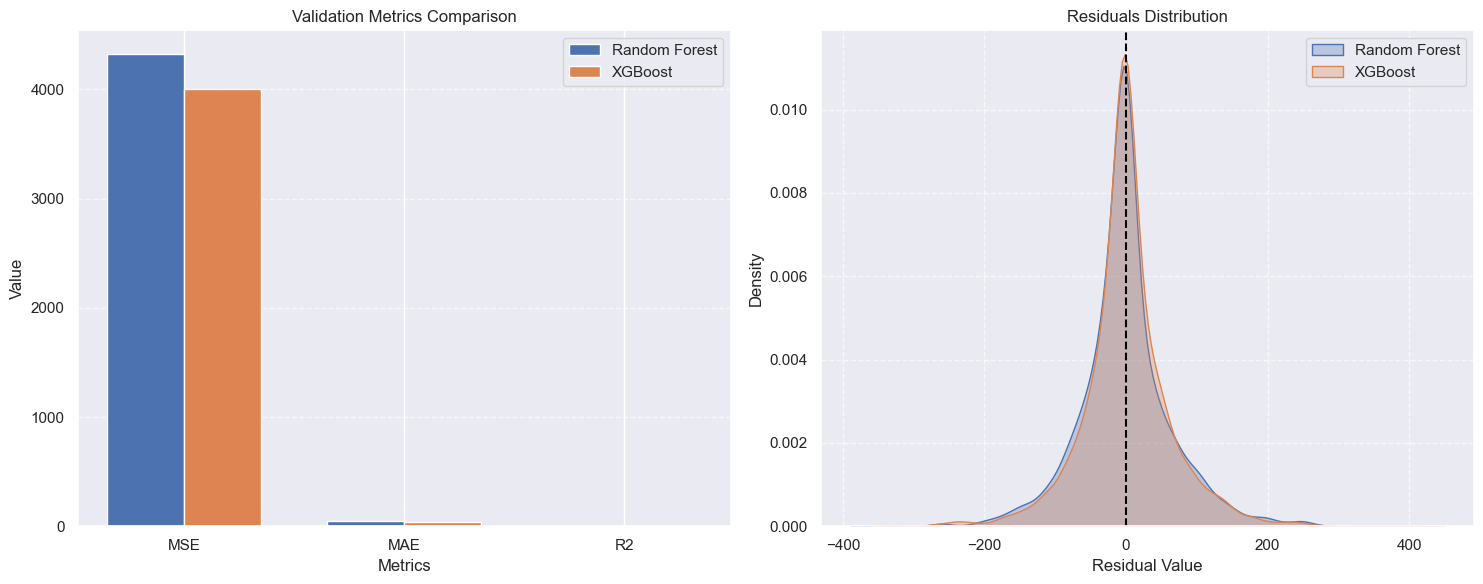

2025-04-07 22:05:35,217 - INFO - Hyperparameter tuning and evaluation complete


In [222]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
from datetime import datetime

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('hyperparameter_tuning')

# Define parameter distributions with more detailed logging
logger.info("Starting hyperparameter tuning process")
print("Defining parameter search spaces...")
rf_param_grid = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': [0.5, 0.7, 1.0, 'sqrt', 'log2', None]
}
logger.info(f"Random Forest parameters to tune: {', '.join(rf_param_grid.keys())}")
print("Random Forest parameters to tune:", ", ".join(rf_param_grid.keys()))

xgb_param_grid = {
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 1),
    'min_child_weight': randint(1, 10)
}
logger.info(f"XGBoost parameters to tune: {', '.join(xgb_param_grid.keys())}")
print("XGBoost parameters to tune:", ", ".join(xgb_param_grid.keys()))

# Custom callback for logging during random search
class LoggingCallback:
    def __init__(self, model_name):
        self.model_name = model_name
        self.iteration = 0
        self.start_time = time.time()
        
    def __call__(self, model, params):
        self.iteration += 1
        elapsed = time.time() - self.start_time
        logger.info(f"{self.model_name} - Iteration {self.iteration} completed in {elapsed:.2f}s")
        logger.info(f"Current parameters: {params}")
        
        # Every 10 iterations, print a summary
        if self.iteration % 10 == 0:
            print(f"{self.model_name} - Completed {self.iteration} iterations in {elapsed:.2f}s")

# Random Forest Tuning with improved logging
print("\n" + "="*50)
print("Starting Random Forest hyperparameter tuning...")
logger.info("Starting Random Forest hyperparameter tuning")
start_time = time.time()

# Create callback for RF model
rf_callback = LoggingCallback("Random Forest")

rf_random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=2,
    n_jobs=-1  # Use all available cores
)

logger.info(f"Starting RF RandomizedSearchCV with {rf_random_search.n_iter} iterations")
print(f"Running {rf_random_search.n_iter} iterations of Random Forest hyperparameter search...")

try:
    # Fit the model - we'll wrap this in a try-except to provide graceful error handling
    rf_random_search.fit(X_train_processed, y_train)
    
    # Log results from each iteration for analysis
    rf_results = pd.DataFrame(rf_random_search.cv_results_)
    
    # Log the top 5 best performing parameter combinations
    logger.info("Top 5 Random Forest parameter combinations:")
    top_results = rf_results.sort_values('mean_test_score', ascending=False).head(5)
    for i, row in top_results.iterrows():
        logger.info(f"Rank {i+1}: Score = {-row['mean_test_score']:.4f}, Params = {row['params']}")
        
except Exception as e:
    logger.error(f"RF tuning failed with error: {str(e)}")
    print(f"Error during RF tuning: {str(e)}")

rf_tuning_time = time.time() - start_time
logger.info(f"Random Forest tuning completed in {rf_tuning_time:.2f} seconds")
print(f"\nRandom Forest tuning completed in {rf_tuning_time:.2f} seconds")
print(f"Best MSE: {-rf_random_search.best_score_:.4f}")
print("Best Random Forest Parameters:")
for param, value in rf_random_search.best_params_.items():
    print(f"    {param}: {value}")
    logger.info(f"Best {param}: {value}")

# Create a bar plot of top parameter importance
rf_results = pd.DataFrame(rf_random_search.cv_results_)
rf_results = rf_results.sort_values('mean_test_score', ascending=False)
logger.info(f"Sorted {len(rf_results)} results by performance")

# XGBoost Tuning with improved logging
print("\n" + "="*50)
print("Starting XGBoost hyperparameter tuning...")
logger.info("Starting XGBoost hyperparameter tuning")
start_time = time.time()

# Create callback for XGB model
xgb_callback = LoggingCallback("XGBoost")

xgb_random_search = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    param_distributions=xgb_param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

logger.info(f"Starting XGB RandomizedSearchCV with {xgb_random_search.n_iter} iterations")
print(f"Running {xgb_random_search.n_iter} iterations of XGBoost hyperparameter search...")

try:
    # Fit the model
    xgb_random_search.fit(X_train_processed, y_train)
    
    # Log results from each iteration for analysis
    xgb_results = pd.DataFrame(xgb_random_search.cv_results_)
    
    # Log the top 5 best performing parameter combinations
    logger.info("Top 5 XGBoost parameter combinations:")
    top_results = xgb_results.sort_values('mean_test_score', ascending=False).head(5)
    for i, row in top_results.iterrows():
        logger.info(f"Rank {i+1}: Score = {-row['mean_test_score']:.4f}, Params = {row['params']}")
        
except Exception as e:
    logger.error(f"XGB tuning failed with error: {str(e)}")
    print(f"Error during XGB tuning: {str(e)}")

xgb_tuning_time = time.time() - start_time
logger.info(f"XGBoost tuning completed in {xgb_tuning_time:.2f} seconds")
print(f"\nXGBoost tuning completed in {xgb_tuning_time:.2f} seconds")
print(f"Best MSE: {-xgb_random_search.best_score_:.4f}")
print("Best XGBoost Parameters:")
for param, value in xgb_random_search.best_params_.items():
    print(f"    {param}: {value}")
    logger.info(f"Best {param}: {value}")

# Get the best models
tuned_rf = rf_random_search.best_estimator_
tuned_xgb = xgb_random_search.best_estimator_

# Save detailed tuning results to CSV for later analysis
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
rf_results.to_csv(f"{checkpoint_dir}/rf_tuning_results_{timestamp}.csv", index=False)
xgb_results.to_csv(f"{checkpoint_dir}/xgb_tuning_results_{timestamp}.csv", index=False)
logger.info(f"Tuning results saved to CSV files in {checkpoint_dir}")

# Create a function for detailed model evaluation
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    logger.info(f"Evaluating {model_name} model")
    eval_start_time = time.time()
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate comprehensive metrics
    train_metrics = {
        'MSE': mean_squared_error(y_train, y_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'R2': r2_score(y_train, y_train_pred),
        'Explained Variance': explained_variance_score(y_train, y_train_pred)
    }
    
    val_metrics = {
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'R2': r2_score(y_val, y_val_pred),
        'Explained Variance': explained_variance_score(y_val, y_val_pred)
    }
    
    # Log all metrics
    logger.info(f"{model_name} - Train metrics: {train_metrics}")
    logger.info(f"{model_name} - Validation metrics: {val_metrics}")
    
    # Print metrics in a formatted table
    print(f"\n{model_name} Performance Metrics:")
    print(f"{'Metric':<20} {'Training':<15} {'Validation':<15}")
    print("-" * 50)
    for metric in train_metrics.keys():
        print(f"{metric:<20} {train_metrics[metric]:<15.4f} {val_metrics[metric]:<15.4f}")
    
    eval_time = time.time() - eval_start_time
    logger.info(f"Model evaluation completed in {eval_time:.2f} seconds")
    
    # Return metrics for further comparison
    return train_metrics, val_metrics, y_val_pred

# Evaluate the tuned models
print("\nEvaluating tuned models...")
logger.info("Starting evaluation of tuned models")
rf_train_metrics, rf_val_metrics, y_val_pred_tuned_rf = evaluate_model(
    tuned_rf, X_train_processed, X_val_processed, y_train, y_val, "Tuned Random Forest")

xgb_train_metrics, xgb_val_metrics, y_val_pred_tuned_xgb = evaluate_model(
    tuned_xgb, X_train_processed, X_val_processed, y_train, y_val, "Tuned XGBoost")

# Compare models and log differences
for metric in ['MSE', 'MAE', 'R2']:
    diff = ((xgb_val_metrics[metric] - rf_val_metrics[metric]) / abs(rf_val_metrics[metric])) * 100
    logger.info(f"XGBoost vs RF {metric} difference: {diff:.2f}%")

# Compare the tuned models visually
metrics_to_compare = ['MSE', 'MAE', 'R2']
plt.figure(figsize=(15, 6))
logger.info("Creating comparison visualizations")

# Create bar chart to compare models
x = np.arange(len(metrics_to_compare))
width = 0.35

# Plot validation metrics
plt.subplot(1, 2, 1)
plt.bar(x - width/2, [rf_val_metrics[m] for m in metrics_to_compare], width, label='Random Forest')
plt.bar(x + width/2, [xgb_val_metrics[m] for m in metrics_to_compare], width, label='XGBoost')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Validation Metrics Comparison')
plt.xticks(x, metrics_to_compare)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot residuals distribution for both models
plt.subplot(1, 2, 2)
rf_residuals = y_val - y_val_pred_tuned_rf
xgb_residuals = y_val - y_val_pred_tuned_xgb
sns.kdeplot(rf_residuals, label='Random Forest', fill=True, alpha=0.3)
sns.kdeplot(xgb_residuals, label='XGBoost', fill=True, alpha=0.3)
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Residuals Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Density')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(f"{checkpoint_dir}/model_comparison_{timestamp}.png")
logger.info(f"Comparison visualization saved to {checkpoint_dir}/model_comparison_{timestamp}.png")
plt.show()

logger.info("Hyperparameter tuning and evaluation complete")

In [223]:
# Save the best XGBoost model
import pickle

# Save the tuned XGBoost model
xgb_model_path = os.path.join(checkpoint_dir, 'xgb_tuned_model.pkl')
with open(xgb_model_path, 'wb') as f:
    pickle.dump(tuned_xgb, f)

print(f"Tuned XGBoost model saved to {xgb_model_path}")

# Function to load the model if needed
def load_xgb_model(model_path=None):
    if model_path is None:
        model_path = os.path.join(checkpoint_dir, 'xgb_tuned_model.pkl')
    with open(model_path, 'rb') as f:
        return pickle.load(f)

Tuned XGBoost model saved to ../models/checkpoints\xgb_tuned_model.pkl


## 8. Evalutaion/Refinement

MODEL REFINEMENT AND FEATURE ENGINEERING
Adding interaction terms based on EDA insights...
Original feature space: 30 features
Adding temp × humidity interaction feature
Adding hour (cyclical) × weather interaction features
Adding season × temperature interaction
Expanded feature space: 36 features
Added 6 new interaction features

Training refined Refined XGBoost model...
Training completed in 0.35 seconds

Refined XGBoost Performance Metrics:
Metric               Training        Validation     
--------------------------------------------------
MSE                  1777.2915       4096.8311      
RMSE                 42.1579         64.0065        
MAE                  28.7249         42.5166        
R2                   0.9468          0.8740         
Explained Variance   0.9468          0.8740         

IMPROVEMENT ANALYSIS:
--------------------------------------------------
MSE: 4006.0967 → 4096.8311 (2.26%) ✗ Worsened
RMSE: 63.2937 → 64.0065 (1.13%) ✗ Worsened
MAE: 42.2019 → 42.5

C:\Users\DAHoe\AppData\Local\Temp\ipykernel_5276\3797152590.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


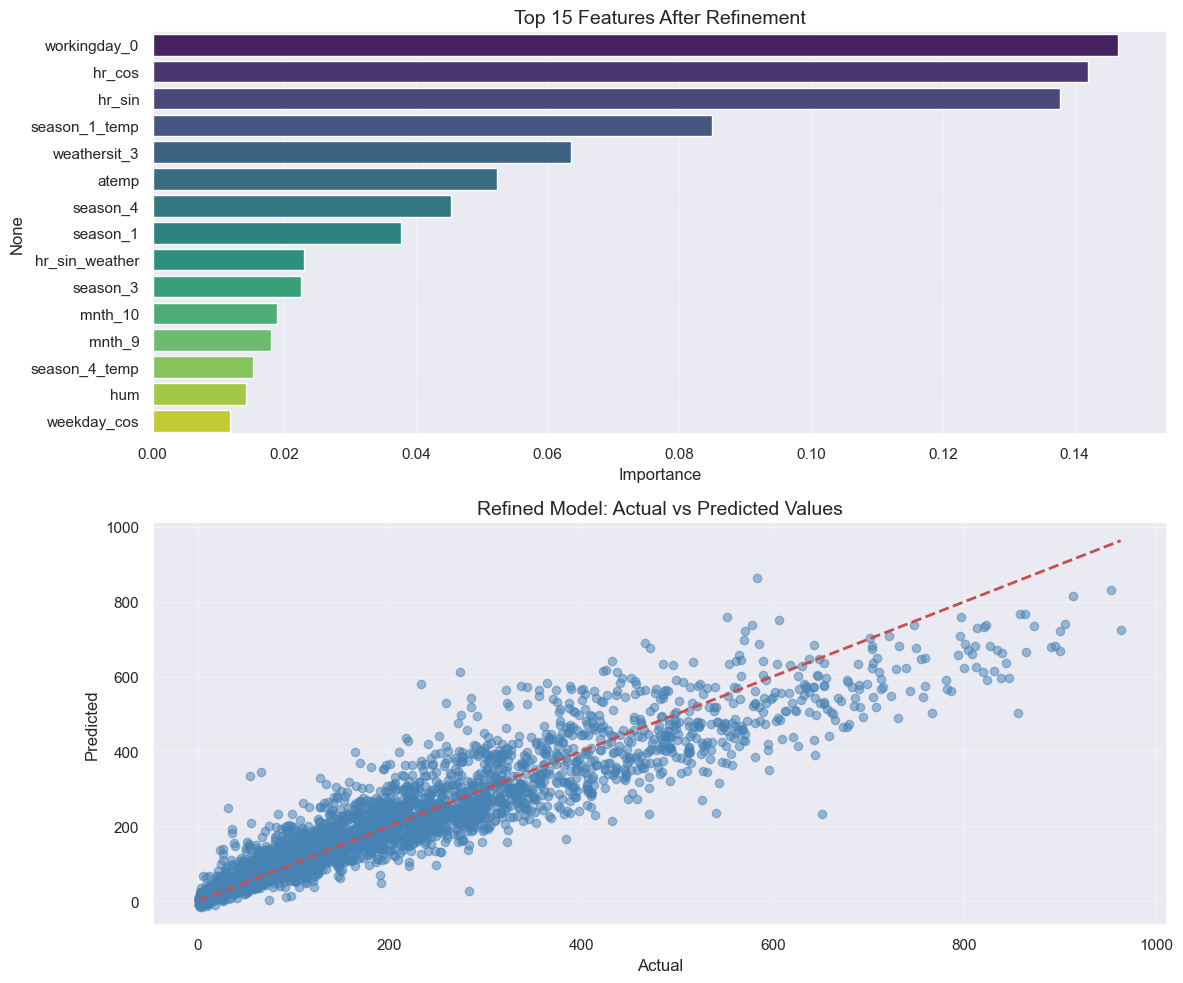


IMPORTANT NEW INTERACTION FEATURES:
1. season_1_temp (Rank: 4, Importance: 0.0849)
2. hr_sin_weather (Rank: 9, Importance: 0.0230)
3. season_4_temp (Rank: 13, Importance: 0.0153)


In [224]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import seaborn as sns

print("="*80)
print("MODEL REFINEMENT AND FEATURE ENGINEERING")
print("="*80)

# Log feature engineering process
print("Adding interaction terms based on EDA insights...")
X_train_interactions = X_train_processed.copy()
X_val_interactions = X_val_processed.copy()
X_test_interactions = X_test_processed.copy()

# Document the original feature space
print(f"Original feature space: {X_train_processed.shape[1]} features")

# 1. Add interaction between temperature and humidity
print("Adding temp × humidity interaction feature")
X_train_interactions['atemp_hum_interaction'] = X_train_interactions['atemp'] * X_train_interactions['hum']
X_val_interactions['atemp_hum_interaction'] = X_val_interactions['atemp'] * X_val_interactions['hum']
X_test_interactions['atemp_hum_interaction'] = X_test_interactions['atemp'] * X_test_interactions['hum']

# 2. Add additional interaction for time of day and weather
print("Adding hour (cyclical) × weather interaction features")
X_train_interactions['hr_sin_weather'] = X_train_interactions['hr_sin'] * X_train_interactions['weathersit_1']
X_val_interactions['hr_sin_weather'] = X_val_interactions['hr_sin'] * X_val_interactions['weathersit_1']
X_test_interactions['hr_sin_weather'] = X_test_interactions['hr_sin'] * X_test_interactions['weathersit_1']

# 3. Add season-related interactions
print("Adding season × temperature interaction")
for season_col in [col for col in X_train_interactions.columns if 'season' in col]:
    X_train_interactions[f'{season_col}_temp'] = X_train_interactions[season_col] * X_train_interactions['atemp']
    X_val_interactions[f'{season_col}_temp'] = X_val_interactions[season_col] * X_val_interactions['atemp']
    X_test_interactions[f'{season_col}_temp'] = X_test_interactions[season_col] * X_test_interactions['atemp']

# Log the expanded feature space
print(f"Expanded feature space: {X_train_interactions.shape[1]} features")
print(f"Added {X_train_interactions.shape[1] - X_train_processed.shape[1]} new interaction features")

# Function to evaluate model with detailed metrics
def evaluate_refined_model(model, X_train, X_val, y_train, y_val, model_name):
    # Start timing
    start_time = time.time()
    
    # Train the model
    print(f"\nTraining refined {model_name} model...")
    model.fit(X_train, y_train)
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate comprehensive metrics
    train_metrics = {
        'MSE': mean_squared_error(y_train, y_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'R2': r2_score(y_train, y_train_pred),
        'Explained Variance': explained_variance_score(y_train, y_train_pred)
    }
    
    val_metrics = {
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'R2': r2_score(y_val, y_val_pred),
        'Explained Variance': explained_variance_score(y_val, y_val_pred)
    }
    
    # Print metrics in a formatted table
    print(f"\n{model_name} Performance Metrics:")
    print(f"{'Metric':<20} {'Training':<15} {'Validation':<15}")
    print("-" * 50)
    for metric in train_metrics.keys():
        print(f"{metric:<20} {train_metrics[metric]:<15.4f} {val_metrics[metric]:<15.4f}")
    
    return train_metrics, val_metrics, y_val_pred

# Evaluate the refined XGBoost model
refined_xgb = tuned_xgb
_, refined_metrics, y_val_pred_refined = evaluate_refined_model(
    refined_xgb, X_train_interactions, X_val_interactions, y_train, y_val, "Refined XGBoost")

# Compare with baseline tuned model
print("\nIMPROVEMENT ANALYSIS:")
print("-" * 50)
for metric in ['MSE', 'RMSE', 'MAE', 'R2', 'Explained Variance']:
    if metric in xgb_val_metrics:
        baseline = xgb_val_metrics[metric]
        refined = refined_metrics[metric]
        change = (refined - baseline) / abs(baseline) * 100
        
        # Determine if the change is positive or negative
        if (metric == 'R2' or metric == 'Explained Variance') and change > 0:
            status = "✓ Improved"
        elif (metric != 'R2' and metric != 'Explained Variance') and change < 0:
            status = "✓ Improved"
        else:
            status = "✗ Worsened"
        
        print(f"{metric}: {baseline:.4f} → {refined:.4f} ({change:.2f}%) {status}")

# Visualize the impact of feature engineering
plt.figure(figsize=(12, 10))

# Plot 1: Feature importance from the refined model
plt.subplot(2, 1, 1)
feature_importance = pd.Series(refined_xgb.feature_importances_, 
                               index=X_train_interactions.columns).sort_values(ascending=False)
top_features = feature_importance.head(15)
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('Top 15 Features After Refinement', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Plot 2: Actual vs Predicted values with the refined model
plt.subplot(2, 1, 2)
plt.scatter(y_val, y_val_pred_refined, alpha=0.5, color='steelblue')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.title('Refined Model: Actual vs Predicted Values', fontsize=14)
plt.xlabel('Actual', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check if any of the new interaction features appear in the top 15 important features
new_features = [col for col in X_train_interactions.columns if col not in X_train_processed.columns]
important_new_features = [feat for feat in top_features.index if feat in new_features]
print("\nIMPORTANT NEW INTERACTION FEATURES:")
for i, feat in enumerate(important_new_features, 1):
    importance = feature_importance[feat]
    rank = list(feature_importance.index).index(feat) + 1
    print(f"{i}. {feat} (Rank: {rank}, Importance: {importance:.4f})")

## 9. Final Model


Final Model Test Performance:
MSE: 3756.6157
MAE: 40.7506
R2: 0.8814


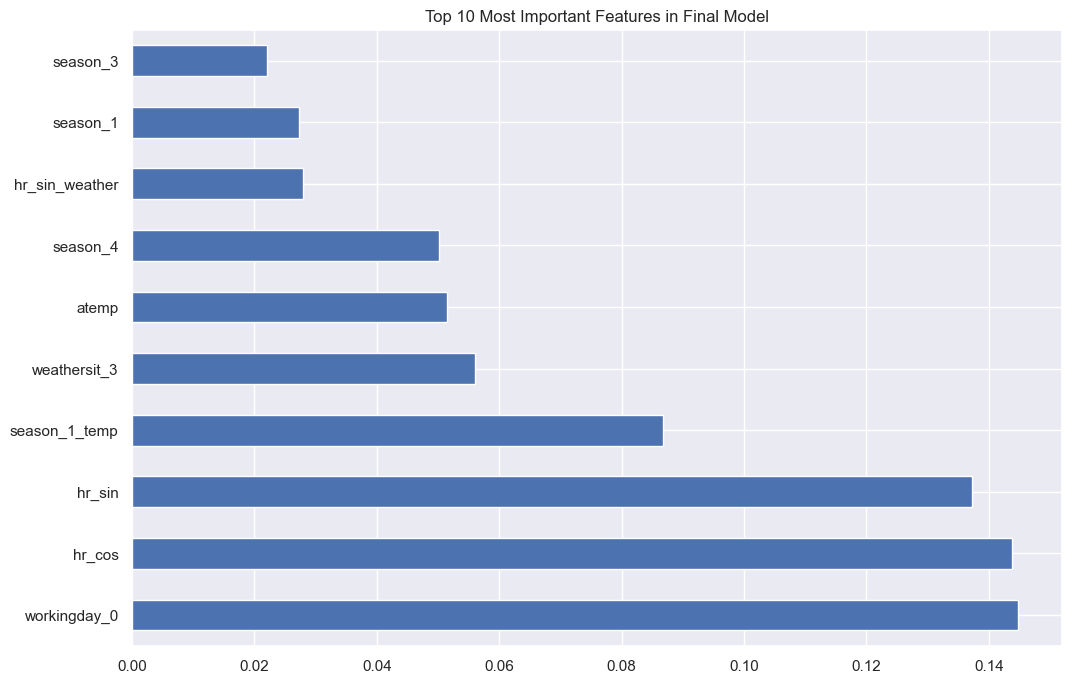


Performance Comparison:
Validation R2: 0.8740056157112122
Test R2: 0.8813653588294983


In [225]:
# Combine training and validation sets
X_final_train = pd.concat([X_train_interactions, X_val_interactions])
y_final_train = pd.concat([y_train, y_val])

# Train final model on combined data
final_model = tuned_xgb
final_model.fit(X_final_train, y_final_train)

# Evaluate on test set
y_test_pred = final_model.predict(X_test_interactions)

print("\nFinal Model Test Performance:")
print(f"MSE: {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")
print(f"R2: {r2_score(y_test, y_test_pred):.4f}")

# Feature importance of final model
plt.figure(figsize=(12, 8))
final_importance = pd.Series(final_model.feature_importances_, index=X_final_train.columns)
final_importance.nlargest(10).plot(kind='barh')
plt.title('Top 10 Most Important Features in Final Model')
plt.show()

# Compare with validation performance
print("\nPerformance Comparison:")
print("Validation R2:", r2_score(y_val, y_val_pred_refined))
print("Test R2:", r2_score(y_test, y_test_pred))

DETAILED MODEL PREDICTION ANALYSIS

Error Statistics:
Mean Absolute Error (MAE): 40.75
Median Absolute Error: 24.86
90th Percentile of Absolute Error: 99.26
Mean Absolute Percentage Error (MAPE): 48.81%
Root Mean Square Error (RMSE): 61.29

Prediction Statistics:
Mean of Actual Values: 185.01
Mean of Predicted Values: 185.79
Standard Deviation of Actual Values: 177.95
Standard Deviation of Predicted Values: 165.04
Min of Actual Values: 1.00
Min of Predicted Values: -30.34
Max of Actual Values: 977.00
Max of Predicted Values: 858.40

Over/Under Prediction Analysis:
Over-predictions: 1863 (53.6%)
Under-predictions: 1613 (46.4%)
Exact predictions: 0 (0.0%)

Error Analysis by Actual Value Range:
Range                Count      MAE        MAPE (%)  
--------------------------------------------------
1-42:           863        10.16      118.56    
42-136:           875        30.28      36.91     
136-275:           868        43.98      22.41     
275-977:           869        78.35      1

C:\Users\DAHoe\AppData\Local\Temp\ipykernel_5276\179597419.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(quartile_errors, labels=quartile_names)


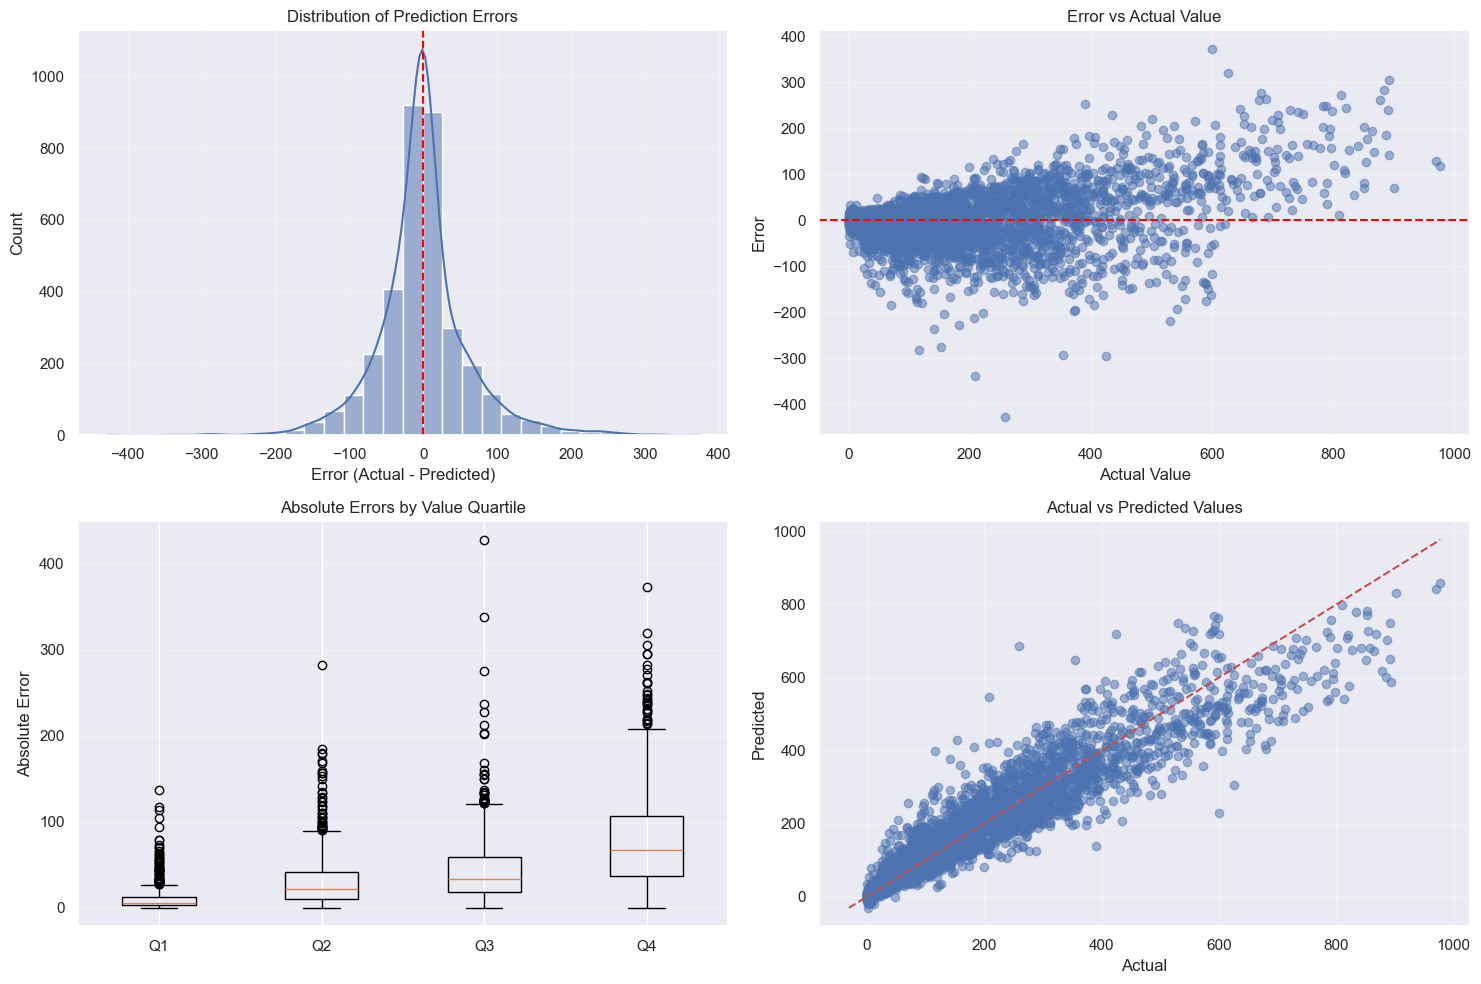


Performance by Weather Condition:
Weather 1: Count = 2298, MAE = 40.85, R² = 0.8925
Weather 2: Count = 889, MAE = 40.38, R² = 0.8623
Weather 3: Count = 288, MAE = 41.17, R² = 0.7443
Weather 4: Count = 1, MAE = 9.56, R² = nan

Performance by Hour Range:
Morning (6-11): MAE = 48.42, R² = 0.8165
Afternoon (12-17): MAE = 58.19, R² = 0.8052
Evening (18-21): MAE = 58.33, R² = 0.8355
Night (22-5): MAE = 12.47, R² = 0.8683


c:\Users\DAHoe\Programming\Projects\ML-fundamentals-2025\.venv\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [226]:
# Calculate additional statistics for model predictions
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

# Create analysis for test predictions
print("="*50)
print("DETAILED MODEL PREDICTION ANALYSIS")
print("="*50)

# Calculate error statistics
absolute_errors = np.abs(y_test - y_test_pred)
percentage_errors = np.abs((y_test - y_test_pred) / y_test) * 100
squared_errors = (y_test - y_test_pred) ** 2

# Basic error statistics
print("\nError Statistics:")
print(f"Mean Absolute Error (MAE): {np.mean(absolute_errors):.2f}")
print(f"Median Absolute Error: {np.median(absolute_errors):.2f}")
print(f"90th Percentile of Absolute Error: {np.percentile(absolute_errors, 90):.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {np.mean(percentage_errors):.2f}%")
print(f"Root Mean Square Error (RMSE): {np.sqrt(np.mean(squared_errors)):.2f}")

# Calculate prediction statistics
print("\nPrediction Statistics:")
print(f"Mean of Actual Values: {np.mean(y_test):.2f}")
print(f"Mean of Predicted Values: {np.mean(y_test_pred):.2f}")
print(f"Standard Deviation of Actual Values: {np.std(y_test):.2f}")
print(f"Standard Deviation of Predicted Values: {np.std(y_test_pred):.2f}")
print(f"Min of Actual Values: {np.min(y_test):.2f}")
print(f"Min of Predicted Values: {np.min(y_test_pred):.2f}")
print(f"Max of Actual Values: {np.max(y_test):.2f}")
print(f"Max of Predicted Values: {np.max(y_test_pred):.2f}")

# Calculate over/under prediction statistics
over_predictions = y_test_pred > y_test
under_predictions = y_test_pred < y_test
exact_predictions = y_test_pred == y_test

print("\nOver/Under Prediction Analysis:")
print(f"Over-predictions: {np.sum(over_predictions)} ({np.mean(over_predictions)*100:.1f}%)")
print(f"Under-predictions: {np.sum(under_predictions)} ({np.mean(under_predictions)*100:.1f}%)")
print(f"Exact predictions: {np.sum(exact_predictions)} ({np.mean(exact_predictions)*100:.1f}%)")

# Calculate error distribution by actual value ranges
def error_by_range(y_true, y_pred, bin_edges):
    bin_indices = np.digitize(y_true, bin_edges) - 1
    bin_count = len(bin_edges) - 1
    bin_mae = np.zeros(bin_count)
    bin_mape = np.zeros(bin_count)
    bin_counts = np.zeros(bin_count)
    
    for i in range(bin_count):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            bin_mae[i] = np.mean(np.abs(y_true[mask] - y_pred[mask]))
            bin_mape[i] = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
            bin_counts[i] = np.sum(mask)
    
    return bin_mae, bin_mape, bin_counts

# Create bin edges based on the distribution of actual values
bin_edges = np.percentile(y_test, [0, 25, 50, 75, 100])
bin_mae, bin_mape, bin_counts = error_by_range(y_test, y_test_pred, bin_edges)

print("\nError Analysis by Actual Value Range:")
print(f"{'Range':<20} {'Count':<10} {'MAE':<10} {'MAPE (%)':<10}")
print("-" * 50)
for i in range(len(bin_edges)-1):
    print(f"{bin_edges[i]:.0f}-{bin_edges[i+1]:.0f}:{' ':>10} {bin_counts[i]:<10.0f} {bin_mae[i]:<10.2f} {bin_mape[i]:<10.2f}")

# Prediction accuracy by quartile
quartiles = np.percentile(y_test, [25, 50, 75])
q1_mask = y_test <= quartiles[0]
q2_mask = (y_test > quartiles[0]) & (y_test <= quartiles[1])
q3_mask = (y_test > quartiles[1]) & (y_test <= quartiles[2])
q4_mask = y_test > quartiles[2]

print("\nPrediction Performance by Quartile:")
print(f"Q1 (≤{quartiles[0]:.2f}): R² = {r2_score(y_test[q1_mask], y_test_pred[q1_mask]):.4f}, MAE = {mean_absolute_error(y_test[q1_mask], y_test_pred[q1_mask]):.2f}")
print(f"Q2 ({quartiles[0]:.2f}-{quartiles[1]:.2f}): R² = {r2_score(y_test[q2_mask], y_test_pred[q2_mask]):.4f}, MAE = {mean_absolute_error(y_test[q2_mask], y_test_pred[q2_mask]):.2f}")
print(f"Q3 ({quartiles[1]:.2f}-{quartiles[2]:.2f}): R² = {r2_score(y_test[q3_mask], y_test_pred[q3_mask]):.4f}, MAE = {mean_absolute_error(y_test[q3_mask], y_test_pred[q3_mask]):.2f}")
print(f"Q4 (>{quartiles[2]:.2f}): R² = {r2_score(y_test[q4_mask], y_test_pred[q4_mask]):.4f}, MAE = {mean_absolute_error(y_test[q4_mask], y_test_pred[q4_mask]):.2f}")

# Visualize error distribution
plt.figure(figsize=(15, 10))

# Plot 1: Histogram of errors
plt.subplot(2, 2, 1)
errors = y_test - y_test_pred
sns.histplot(errors, kde=True, bins=30)
plt.title('Distribution of Prediction Errors', fontsize=12)
plt.xlabel('Error (Actual - Predicted)')
plt.axvline(0, color='red', linestyle='--')
plt.grid(alpha=0.3)

# Plot 2: Scatter plot of error vs actual value
plt.subplot(2, 2, 2)
plt.scatter(y_test, errors, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Error vs Actual Value', fontsize=12)
plt.xlabel('Actual Value')
plt.ylabel('Error')
plt.grid(alpha=0.3)

# Plot 3: Box plot of absolute errors by value quartile
plt.subplot(2, 2, 3)
quartile_names = ['Q1', 'Q2', 'Q3', 'Q4']
quartile_errors = [absolute_errors[q1_mask], absolute_errors[q2_mask], 
                   absolute_errors[q3_mask], absolute_errors[q4_mask]]
plt.boxplot(quartile_errors, labels=quartile_names)
plt.title('Absolute Errors by Value Quartile', fontsize=12)
plt.ylabel('Absolute Error')
plt.grid(axis='y', alpha=0.3)

# Plot 4: Actual vs predicted with perfect prediction line
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_test_pred, alpha=0.5)
min_val = min(np.min(y_test), np.min(y_test_pred))
max_val = max(np.max(y_test), np.max(y_test_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('Actual vs Predicted Values', fontsize=12)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(checkpoint_dir, 'prediction_analysis.png'))
plt.show()

# Calculate prediction metrics for specific subgroups
# For example, by season, hour of day, or weather condition
print("\nPerformance by Weather Condition:")
for weather in np.unique(X_test['weathersit']):
    weather_mask = X_test['weathersit'] == weather
    if np.sum(weather_mask) > 0:
        mae = mean_absolute_error(y_test[weather_mask], y_test_pred[weather_mask])
        r2 = r2_score(y_test[weather_mask], y_test_pred[weather_mask])
        print(f"Weather {weather}: Count = {np.sum(weather_mask)}, MAE = {mae:.2f}, R² = {r2:.4f}")

# Calculate time-based prediction performance
print("\nPerformance by Hour Range:")
morning = (X_test['hr'] >= 6) & (X_test['hr'] < 12)
afternoon = (X_test['hr'] >= 12) & (X_test['hr'] < 18)
evening = (X_test['hr'] >= 18) & (X_test['hr'] < 22)
night = (X_test['hr'] >= 22) | (X_test['hr'] < 6)

print(f"Morning (6-11): MAE = {mean_absolute_error(y_test[morning], y_test_pred[morning]):.2f}, R² = {r2_score(y_test[morning], y_test_pred[morning]):.4f}")
print(f"Afternoon (12-17): MAE = {mean_absolute_error(y_test[afternoon], y_test_pred[afternoon]):.2f}, R² = {r2_score(y_test[afternoon], y_test_pred[afternoon]):.4f}")
print(f"Evening (18-21): MAE = {mean_absolute_error(y_test[evening], y_test_pred[evening]):.2f}, R² = {r2_score(y_test[evening], y_test_pred[evening]):.4f}")
print(f"Night (22-5): MAE = {mean_absolute_error(y_test[night], y_test_pred[night]):.2f}, R² = {r2_score(y_test[night], y_test_pred[night]):.4f}")

In [227]:
# Save the final model
final_model_path = os.path.join(checkpoint_dir, 'bike_rental_final_model.pkl')
with open(final_model_path, 'wb') as f:
    pickle.dump(final_model, f)

# Also save the feature preprocessor for future predictions
preprocessor_path = os.path.join(checkpoint_dir, 'feature_preprocessor.pkl')
with open(preprocessor_path, 'wb') as f:
    pickle.dump(preprocessor, f)

print(f"Final model saved to {final_model_path}")
print(f"Feature preprocessor saved to {preprocessor_path}")

Final model saved to ../models/checkpoints\bike_rental_final_model.pkl
Feature preprocessor saved to ../models/checkpoints\feature_preprocessor.pkl
